In [1]:
from math import erf, sqrt
from dataclasses import dataclass
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time

In [2]:
def norm_cdf(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def bs_price(S, K, T, r, sigma, q=0.0, option_type="call"):
    option_type = option_type.lower()

    if T <= 0:
        if option_type == "call":
            return max(S - K, 0.0)
        elif option_type == "put":
            return max(K - S, 0.0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

    if sigma <= 0:
        F = S * np.exp((r - q) * T)
        disc = np.exp(-r * T)
        if option_type == "call":
            return disc * max(F - K, 0.0)
        elif option_type == "put":
            return disc * max(K - F, 0.0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    disc_r = np.exp(-r * T)
    disc_q = np.exp(-q * T)

    if option_type == "call":
        return float(S * disc_q * norm_cdf(d1) - K * disc_r * norm_cdf(d2))
    elif option_type == "put":
        return float(K * disc_r * norm_cdf(-d2) - S * disc_q * norm_cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

In [3]:
def fetch_spot(ticker):
    t = yf.Ticker(ticker)
    try:
        px = t.fast_info.get("last_price", None)
        if px is not None and float(px) > 0:
            return px
    except Exception:
        pass

    hist = t.history(period="1d", interval="1m")
    if hist.empty:
        raise RuntimeError("Could not fetch spot (empty history).")
    return float(hist["Close"].iloc[-1])

In [4]:
def atm_iv(ticker="XOM", target_days=30):
    t = yf.Ticker(ticker)
#on recupere le prix spot 
    spot = float(t.fast_info.get("last_price") or t.history(period="1d")["Close"].iloc[-1])
#on recupere les echeances des options
    expiries = t.options
    if not expiries:
        raise RuntimeError("No option expiries returned by yfinance.")
#on choisit l'echeance la plus proche de 30 jours
#on calcule le nombre de jours restants pour chaque échéance 
    today = datetime.now(timezone.utc).date()
    exp_dates = []
    dtes = []
    for e in expiries:
        d = datetime.strptime(e, "%Y-%m-%d").date()
        dt = (d - today).days
        if dt > 0:
            exp_dates.append(e)
            dtes.append(dt)

    if not exp_dates:
        raise RuntimeError("No future expiries found.")

    dtes = np.array(dtes)
    idx = int(np.argmin(np.abs(dtes - target_days)))
    expiry = exp_dates[idx]
    dte = int(dtes[idx])

    chain = t.option_chain(expiry)
    calls = chain.calls.copy()
    puts = chain.puts.copy()

    calls["abs_moneyness"] = (calls["strike"] - spot).abs()
    atm_strike = float(calls.sort_values("abs_moneyness").iloc[0]["strike"])

    c_atm = calls.loc[calls["strike"] == atm_strike].iloc[0]
    p_atm = puts.loc[puts["strike"] == atm_strike].iloc[0]

    call_iv = float(c_atm.get("impliedVolatility", np.nan))
    put_iv = float(p_atm.get("impliedVolatility", np.nan))

    if np.isfinite(call_iv) and np.isfinite(put_iv):
        atm_iv = 0.5 * (call_iv + put_iv)
        iv_source = "avg(call_iv, put_iv)"
    elif np.isfinite(call_iv):
        atm_iv = call_iv
        iv_source = "call_iv"
    elif np.isfinite(put_iv):
        atm_iv = put_iv
        iv_source = "put_iv"
    else:
        raise RuntimeError("ATM impliedVolatility is NaN for both call and put.")

    return {
        "ticker": ticker,
        "spot": spot,
        "expiry": expiry,
        "dte": dte,
        "atm_strike": atm_strike,
        "atm_iv": atm_iv,
        "iv_source": iv_source,
        "call_iv": call_iv,
        "put_iv": put_iv,}

In [5]:
def strikes_from_dcf_band(spot, dcf_central, dcf_low_g, dcf_high_g, horizon_months=1, wing_multiplier=2.0, rounding=1.0):
    down_pct = abs(dcf_low_g - dcf_central) / dcf_central
    up_pct = abs(dcf_high_g - dcf_central) / dcf_central
    avg_pct = 0.5 * (down_pct + up_pct)

    time_scale = (horizon_months / 12.0) ** 0.5
    short_range_pct = avg_pct * time_scale

    K2 = spot * (1.0 - short_range_pct)
    K3 = spot * (1.0 + short_range_pct)
    K1 = spot * (1.0 - wing_multiplier * short_range_pct)
    K4 = spot * (1.0 + wing_multiplier * short_range_pct)

    def r(x):
        return float(np.round(x / rounding) * rounding) if rounding > 0 else float(x)

    K1, K2, K3, K4 = r(K1), r(K2), r(K3), r(K4)
    K_sorted = sorted([K1, K2, K3, K4])
    return K_sorted[0], K_sorted[1], K_sorted[2], K_sorted[3]

In [6]:
@dataclass
class Condor:
    K1: float
    K2: float
    K3: float
    K4: float
    qty: int = 1

    def legs_bs(self, S, T, r, sigma, q=0.0):
        c1 = bs_price(S, self.K1, T, r, sigma, q, "call")
        c2 = bs_price(S, self.K2, T, r, sigma, q, "call")
        c3 = bs_price(S, self.K3, T, r, sigma, q, "call")
        c4 = bs_price(S, self.K4, T, r, sigma, q, "call")
        return c1, c2, c3, c4

    def price_bs(self, S, T, r, sigma, q=0.0):
        c1, c2, c3, c4 = self.legs_bs(S, T, r, sigma, q)
        return self.qty * (c1 - c2 - c3 + c4)

    def payoff(self, ST):
        ST = np.asarray(ST)
        return self.qty * (
            np.maximum(ST - self.K1, 0.0)
            - np.maximum(ST - self.K2, 0.0)
            - np.maximum(ST - self.K3, 0.0)
            + np.maximum(ST - self.K4, 0.0))

In [7]:
def plot_payoff(condor, S0, premium):
    lo = max(0.01, 0.6 * S0)
    hi = 1.4 * S0
    ST = np.linspace(lo, hi, 500)
    profit = condor.payoff(ST) - premium

    plt.figure()
    plt.plot(ST, profit)
    plt.axhline(0.0)
    plt.axvline(S0)
    plt.title("Condor Profit at Expiry (payoff - premium)")
    plt.xlabel("Underlying price at expiry (ST)")
    plt.ylabel("Profit")
    plt.tight_layout()
    plt.show()


def plot_price_sweep(condor, S0, T, r, sigma, q=0.0):
    lo = max(0.01, 0.8 * S0)
    hi = 1.2 * S0
    S_grid = np.linspace(lo, hi, 250)
    prices = np.array([condor.price_bs(S, T, r, sigma, q) for S in S_grid])

    plt.figure()
    plt.plot(S_grid, prices)
    plt.axvline(S0)
    plt.title("Condor Mark-to-Market vs Spot (Black–Scholes)")
    plt.xlabel("Spot (S)")
    plt.ylabel("Condor price")
    plt.tight_layout()
    plt.show()

In [8]:
def run_hourly(ticker, T_years, r, q, condor, refresh_seconds=3600, iv_target_days=30,):
    log_rows = []
    print(f"Monitoring {ticker} | refresh={refresh_seconds}s | IV target={iv_target_days}D")
    print("Stop: Ctrl+C (script) or Kernel -> Interrupt (Jupyter)\n")

    try:
        while True:
            ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            iv = atm_iv(ticker, target_days=iv_target_days)
            S = float(iv["spot"])
            sigma = float(iv["atm_iv"])
            expiry = iv["expiry"]
            dte = iv["dte"]

            c1, c2, c3, c4 = condor.legs_bs(S, T_years, r, sigma, q)
            strat = condor.qty * (c1 - c2 - c3 + c4)

            row = {
                "timestamp_local": ts,
                "spot": S,
                "sigma_atm_iv": sigma,
                "iv_expiry": expiry,
                "iv_dte": dte,
                "condor_price": strat,
                "leg_+C_K1": condor.qty * (c1),
                "leg_-C_K2": condor.qty * (-c2),
                "leg_-C_K3": condor.qty * (-c3),
                "leg_+C_K4": condor.qty * (c4),
                "K1": condor.K1,
                "K2": condor.K2,
                "K3": condor.K3,
                "K4": condor.K4,}
            log_rows.append(row)

            print(
                f"[{ts}] S={S:.2f} | IV={sigma:.3f} (exp {expiry}, {dte}D) | Condor={strat:.4f} | "
                f"Legs: +C({condor.K1})={c1:.4f}, -C({condor.K2})={c2:.4f}, "
                f"-C({condor.K3})={c3:.4f}, +C({condor.K4})={c4:.4f}")

            pd.DataFrame(log_rows).to_csv(f"{ticker}_condor_iv_log.csv", index=False)

            time.sleep(refresh_seconds)

    except KeyboardInterrupt:
        print("\nStopped.")

In [9]:
def run_monitor(ticker, T_years, r, q, condor, refresh_seconds=60, n_points=30, iv_target_days=30, csv_path="XOM_condor_timeseries.csv"): 
    rows = []

    for i in range(n_points):
        ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        iv = atm_iv(ticker, target_days=iv_target_days)
        S = float(iv["spot"])
        sigma = float(iv["atm_iv"])

        condor_px = condor.price_bs(S, T_years, r, sigma, q)

        rows.append({
            "timestamp": ts,
            "spot": S,
            "sigma_iv": sigma,
            "condor_price": condor_px,
            "iv_expiry": iv["expiry"],
            "iv_dte": iv["dte"],
            "K1": condor.K1,
            "K2": condor.K2,
            "K3": condor.K3,
            "K4": condor.K4,})

        print(f"[{i+1}/{n_points}] {ts} | S={S:.2f} | IV={sigma:.3f} | Condor={condor_px:.4f}")

        pd.DataFrame(rows).to_csv(csv_path, index=False)

        if i < n_points - 1:
            time.sleep(refresh_seconds)

    return pd.DataFrame(rows)

In [10]:
def plot_condor_vs_spot_timeseries(df_or_csv):
    if isinstance(df_or_csv, str):
        df = pd.read_csv(df_or_csv)
    else:
        df = df_or_csv.copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp")

    fig, ax1 = plt.subplots()

    ax1.plot(df["timestamp"], df["spot"])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Stock price (Spot)")

    ax2 = ax1.twinx()
    ax2.plot(df["timestamp"], df["condor_price"])
    ax2.set_ylabel("Condor price")

    plt.title("XOM Spot vs Condor Price (through time)")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

Spot=130.96
ATM IV=0.247 (expiry 2026-02-20, 31 days)
DCF central=141.49 | g-0.5%=130.64 | g+0.5%=151.49
Condor strikes (DCF-calibrated): K1=125.0, K2=128.0, K3=134.0, K4=137.0
Condor premium (BS, using ATM IV) = 1.1093



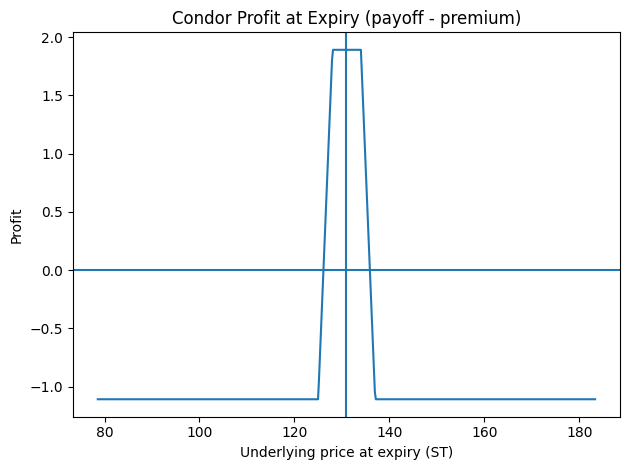

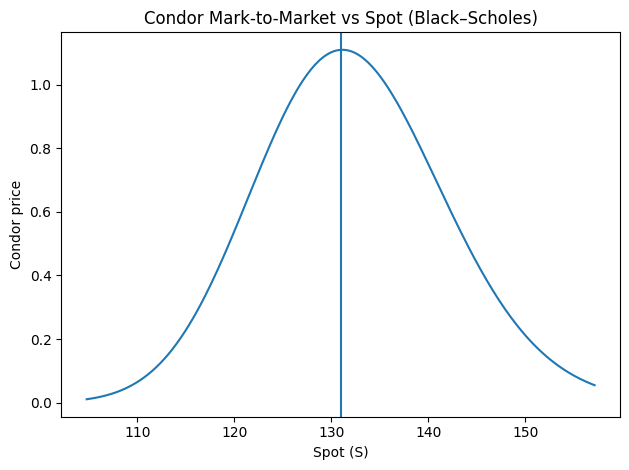

[1/30] 2026-01-20 17:01:43 | S=130.96 | IV=0.247 | Condor=1.1093
[2/30] 2026-01-20 17:02:43 | S=130.93 | IV=0.247 | Condor=1.1085
[3/30] 2026-01-20 17:03:43 | S=130.83 | IV=0.247 | Condor=1.1069
[4/30] 2026-01-20 17:04:44 | S=130.88 | IV=0.247 | Condor=1.1078
[5/30] 2026-01-20 17:05:44 | S=130.88 | IV=0.247 | Condor=1.1073
[6/30] 2026-01-20 17:06:44 | S=130.88 | IV=0.247 | Condor=1.1078
[7/30] 2026-01-20 17:07:44 | S=130.95 | IV=0.247 | Condor=1.1085
[8/30] 2026-01-20 17:08:45 | S=130.99 | IV=0.245 | Condor=1.1164
[9/30] 2026-01-20 17:09:45 | S=130.96 | IV=0.245 | Condor=1.1156
[10/30] 2026-01-20 17:10:45 | S=130.98 | IV=0.247 | Condor=1.1091
[11/30] 2026-01-20 17:11:45 | S=131.05 | IV=0.247 | Condor=1.1104
[12/30] 2026-01-20 17:12:46 | S=130.99 | IV=0.247 | Condor=1.1096
[13/30] 2026-01-20 17:13:46 | S=130.88 | IV=0.247 | Condor=1.1075
[14/30] 2026-01-20 17:14:46 | S=130.88 | IV=0.247 | Condor=1.1076
[15/30] 2026-01-20 17:15:46 | S=130.96 | IV=0.250 | Condor=1.0956
[16/30] 2026-01-20 

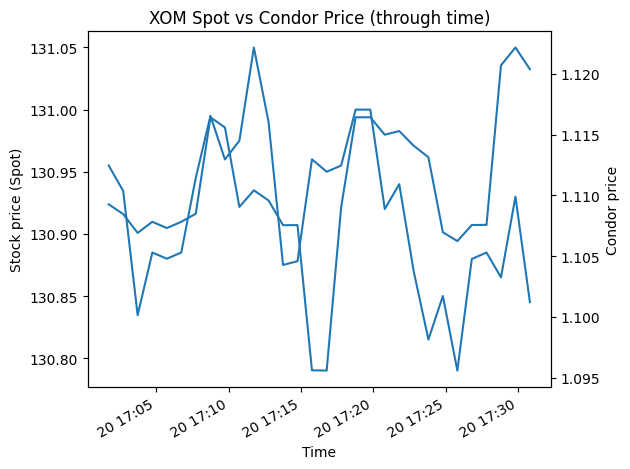

Monitoring XOM | refresh=3600s | IV target=30D
Stop: Ctrl+C (script) or Kernel -> Interrupt (Jupyter)

[2026-01-20 17:30:51] S=130.85 | IV=0.244 (exp 2026-02-20, 31D) | Condor=1.1204 | Legs: +C(125.0)=7.2830, -C(128.0)=5.2616, -C(134.0)=2.3639, +C(137.0)=1.4629


In [ ]:
ticker = "XOM"
T = 30 / 365
r = 0.045
q = 0.035

dcf_central = 141.49  
dcf_low_g   = 130.64  
dcf_high_g  = 151.49  

iv0 = atm_iv(ticker, target_days=30)
S0 = float(iv0["spot"])
sigma0 = float(iv0["atm_iv"])

K1, K2, K3, K4 = strikes_from_dcf_band(
    spot=S0,
    dcf_central=dcf_central,
    dcf_low_g=dcf_low_g,
    dcf_high_g=dcf_high_g,
    horizon_months=1,
    wing_multiplier=2.0,
    rounding=1.0)

condor = Condor(K1=K1, K2=K2, K3=K3, K4=K4, qty=1)
premium0 = condor.price_bs(S0, T, r, sigma0, q)

print(f"Spot={S0:.2f}")
print(f"ATM IV={sigma0:.3f} (expiry {iv0['expiry']}, {iv0['dte']} days)")
print(f"DCF central={dcf_central:.2f} | g-0.5%={dcf_low_g:.2f} | g+0.5%={dcf_high_g:.2f}")
print(f"Condor strikes (DCF-calibrated): K1={K1}, K2={K2}, K3={K3}, K4={K4}")
print(f"Condor premium (BS, using ATM IV) = {premium0:.4f}\n")

plot_payoff(condor, S0, premium0)
plot_price_sweep(condor, S0, T, r, sigma0, q)
df_ts = run_monitor(ticker=ticker, T_years=T, r=r, q=q, condor=condor, refresh_seconds=60, n_points=30, iv_target_days=30,
        csv_path="XOM_condor_timeseries.csv",)
plot_condor_vs_spot_timeseries(df_ts)
run_hourly(ticker=ticker, T_years=T, r=r, q=q, condor=condor, refresh_seconds=3600, iv_target_days=30)